In [ ]:
!git clone https://github.com/Feitong-Zhu/6885-final-drl-Cache

fatal: destination path '6885-final-drl-Cache' already exists and is not an empty directory.


In [ ]:
%cd 6885-final-drl-Cache

/content/6885-final-drl-Cache


# DRL-Based Cache Replacement Policy

In [ ]:
from cache.Cache import Cache
from agents.DQNAgent import DQNAgent
from cache.DataLoader import DataLoaderZipf

## Experiment 1

In [ ]:
from cache.Cache import Cache
from agents.CacheAgent import *
from agents.DQNAgent import DQNAgent
from agents.ReflexAgent import *
from cache.DataLoader import DataLoaderZipf

if __name__ == "__main__":
    # disk activities
    # dataloader = DataLoaderPintos(["data/zipf.csv"])
    dataloader = DataLoaderZipf(2000, 5000, 1.3, num_progs=20)
    hit_rates = {'DQN': [], 'Random': [], 'FIFO': [], 'LFU': [], 'MRU': []}
    sizes = [5, 25, 50, 100, 300]
    for cache_size in sizes:

        print("==================== Cache Size: %d ====================" % cache_size)

        # cache
        env = Cache(dataloader, cache_size
            , feature_selection=('Base',)
            , reward_params = dict(name='our', alpha=0.5, psi=10, mu=1, beta=0.3)
            , allow_skip=False
        )

        # agents
        agents = {}
        agents['DQN'] = DQNAgent(env.n_actions, env.n_features,
            learning_rate=0.01,
            reward_decay=0.9,

            # Epsilon greedy
            e_greedy_min=(0.0, 0.1),
            e_greedy_max=(0.2, 0.8),
            e_greedy_init=(0.1, 0.5),
            e_greedy_increment=(0.005, 0.01),
            e_greedy_decrement=(0.005, 0.001),

            history_size=50,
            dynamic_e_greedy_iter=25,
            reward_threshold=3,
            explore_mentor = 'LRU',

            replace_target_iter=100,
            memory_size=10000,
            batch_size=128,

            output_graph=False,
            verbose=0
        )
        agents['Random'] = RandomAgent(env.n_actions)
        # agents['LRU'] = LRUAgent(env.n_actions)
        agents['FIFO'] = FIFOAgent(env.n_actions)
        agents['LFU'] = LFUAgent(env.n_actions)
        agents['MRU'] = MRUAgent(env.n_actions)
        for (name, agent) in agents.items():

            print("-------------------- %s --------------------" % name)

            step = 0
            miss_rates = []    # record miss rate for every episode
            hitrates = []

            # determine how many episodes to proceed
            # 100 for learning agents, 20 for random agents
            # 1 for other agents because their miss rates are invariant
            if isinstance(agent, LearnerAgent):
                episodes = 10
            elif isinstance(agent, RandomAgent):
                episodes = 5
            else:
                episodes = 1

            for episode in range(episodes):
                # initial observation
                observation = env.reset()

                while True:
                    # agent choose action based on observation
                    action = agent.choose_action(observation)

                    # agent take action and get next observation and reward
                    observation_, reward = env.step(action)

                    # break while loop when end of this episode
                    if env.hasDone():
                        break

                    agent.store_transition(observation, action, reward, observation_)

                    if isinstance(agent, LearnerAgent) and (step > 20) and (step % 5 == 0):
                        agent.learn()

                    # swap observation
                    observation = observation_

                    if step % 100 == 0:
                        mr = env.miss_rate()

                    step += 1

                # report after every episode
                mr = env.miss_rate()
                print("Agent=%s, Episode=%d, Step=%d: Accesses=%d, Misses=%d, MissRate=%f, Hits=%d, HitRate=%f"
                      % (name, episode, step, env.total_count, env.miss_count, mr, env.total_count-env.miss_count, 1-mr)
                    )
                # miss_rates.append(mr)
                hitrates.append(1-mr)

            # summary
            miss_rates = np.array(miss_rates)
            print("Agent=%s, Size=%d: Mean=%f, Median=%f, Max=%f, Min=%f,"
                % (name, cache_size, np.mean(hitrates), np.median(hitrates), np.max(hitrates), np.min(hitrates))
            )

            hit_rates[name].append(np.mean(hitrates))
            print(hit_rates)

    print(hit_rates)
    plt.figure(figsize=(10, 6))
    for name, hit_rate_list in hit_rates.items():
        plt.plot(sizes[:len(hit_rate_list)], hit_rate_list, label=name)

    plt.title("Hit Rates of Different Agents Over Capacity")
    plt.xlabel("capacity")
    plt.ylabel("Hit Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


==================== Cache Size: 5 ====================
-------------------- DQN --------------------
Agent=DQN, Episode=0, Step=65061: Accesses=100000, Misses=65067, MissRate=0.650670, Hits=34933, HitRate=0.349330
Agent=DQN, Episode=1, Step=130157: Accesses=100000, Misses=65102, MissRate=0.651020, Hits=34898, HitRate=0.348980
Agent=DQN, Episode=2, Step=195353: Accesses=100000, Misses=65202, MissRate=0.652020, Hits=34798, HitRate=0.347980
Agent=DQN, Episode=3, Step=260473: Accesses=100000, Misses=65126, MissRate=0.651260, Hits=34874, HitRate=0.348740
Agent=DQN, Episode=4, Step=325636: Accesses=100000, Misses=65169, MissRate=0.651690, Hits=34831, HitRate=0.348310
Agent=DQN, Episode=5, Step=390927: Accesses=100000, Misses=65297, MissRate=0.652970, Hits=34703, HitRate=0.347030
Agent=DQN, Episode=6, Step=456166: Accesses=100000, Misses=65245, MissRate=0.652450, Hits=34755, HitRate=0.347550
Agent=DQN, Episode=7, Step=521304: Accesses=100000, Misses=65144, MissRate=0.651440, Hits=34856, HitR

KeyboardInterrupt: ignored

## Experiment 2

In [ ]:
from cache.Cache import Cache
from agents.CacheAgent import *
from agents.DQNAgent import DQNAgent
from agents.ReflexAgent import *
from cache.DataLoader import DataLoaderZipf
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # cache
    dataloader = DataLoaderZipf(5000, 1000, 1.3, num_progs=15)
    env = Cache(dataloader, 50,
         feature_selection=('Base',),
         reward_params = dict(name='our', alpha=0.5, psi=10, mu=1, beta=0.3),
         allow_skip=False
    )

    # agents
    agents = {}
    agents['DQN'] = DQNAgent(env.n_actions, env.n_features,
        learning_rate=0.01,
        reward_decay=0.9,

        # Epsilon greedy
        e_greedy_min=(0.0, 0.1),
        e_greedy_max=(0.2, 0.8),
        e_greedy_init=(0.1, 0.5),
        e_greedy_increment=(0.005, 0.01),
        e_greedy_decrement=(0.005, 0.001),

        history_size=50,
        dynamic_e_greedy_iter=25,
        reward_threshold=3,
        explore_mentor = 'LRU',

        replace_target_iter=100,
        memory_size=10000,
        batch_size=128,

        output_graph=False,
        verbose=0
    )
    agents['Random'] = RandomAgent(env.n_actions)
    agents['FIFO'] = FIFOAgent(env.n_actions)
    agents['LFU'] = LFUAgent(env.n_actions)
    agents['MRU'] = MRUAgent(env.n_actions)
    hit_rates = {name: [] for name in agents}
    all_counts = []
    # all_steps = []
    for (name, agent) in agents.items():

        print("-------------------- %s --------------------" % name)

        step = 0
        episodes = 1
        # episodes = 2 if isinstance(agent, LearnerAgent) else 1
        counts = []
        steps = []
        for episode in range(episodes):
            # initial observation
            observation = env.reset()
            while True:
                # agent choose action based on observation
                action = agent.choose_action(observation)

                # agent take action and get next observation and reward
                observation_, reward = env.step(action)

                # break while loop when end of this episode
                if env.hasDone():
                    break

                agent.store_transition(observation, action, reward, observation_)

                if isinstance(agent, LearnerAgent) and (step > 20) and (step % 5 == 0):
                    agent.learn()

                # swap observation
                observation = observation_

                if step % 10 == 0:
                  hit_rate = 1 - env.miss_rate()  # Calculate hit rate
                  hit_rates[name].append(hit_rate)  # Store hit rate for the agent
                  mr = env.miss_rate()
                  counts.append(env.total_count)
                  # steps.append(step)

                if step % 1000 == 0:
                  print("Agent=%s, Episode=%d, Step=%d: Accesses=%d, Misses=%d, MissRate=%f, Hits=%d, HitRate=%f"
                      % (name, episode, step, env.total_count, env.miss_count, mr, env.total_count-env.miss_count, 1-mr)
                    )

                step += 1
        all_counts.append(counts)
        # all_steps.append(steps)

    # print(hit_rates)
    plt.figure(figsize=(10, 6))
    for idx,(name, hit_rate_list) in enumerate(hit_rates.items()):
        plt.plot(all_counts[idx], hit_rate_list, label=name)

    plt.title("Hit Rates of Different Agents Over Time")
    plt.xlabel("Number of requests")
    plt.ylabel("Hit Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


-------------------- DQN --------------------
Agent=DQN, Episode=0, Step=0: Accesses=145, Misses=52, MissRate=0.358621, Hits=93, HitRate=0.641379
Agent=DQN, Episode=0, Step=1000: Accesses=3319, Misses=1052, MissRate=0.316963, Hits=2267, HitRate=0.683037
Agent=DQN, Episode=0, Step=2000: Accesses=6360, Misses=2052, MissRate=0.322642, Hits=4308, HitRate=0.677358
Agent=DQN, Episode=0, Step=3000: Accesses=9479, Misses=3052, MissRate=0.321975, Hits=6427, HitRate=0.678025
Agent=DQN, Episode=0, Step=4000: Accesses=12771, Misses=4052, MissRate=0.317281, Hits=8719, HitRate=0.682719
-------------------- Random --------------------
Agent=Random, Episode=0, Step=0: Accesses=135, Misses=52, MissRate=0.385185, Hits=83, HitRate=0.614815
Agent=Random, Episode=0, Step=1000: Accesses=3053, Misses=1052, MissRate=0.344579, Hits=2001, HitRate=0.655421
Agent=Random, Episode=0, Step=2000: Accesses=5612, Misses=2052, MissRate=0.365645, Hits=3560, HitRate=0.634355
Agent=Random, Episode=0, Step=3000: Accesses=83

KeyboardInterrupt: ignored

In [ ]:
import importlib
import cache.DataLoader
importlib.reload(cache.DataLoader)

<module 'cache.DataLoader' from '/content/6885-final-drl-Cache/cache/DataLoader.py'>

## Experiment 3

-------------------- DQN, Zipf Beta=0.6 --------------------
-------------------- Random, Zipf Beta=0.6 --------------------
-------------------- FIFO, Zipf Beta=0.6 --------------------
-------------------- LFU, Zipf Beta=0.6 --------------------
-------------------- MRU, Zipf Beta=0.6 --------------------
-------------------- DQN, Zipf Beta=0.8 --------------------
-------------------- Random, Zipf Beta=0.8 --------------------
-------------------- FIFO, Zipf Beta=0.8 --------------------
-------------------- LFU, Zipf Beta=0.8 --------------------
-------------------- MRU, Zipf Beta=0.8 --------------------
-------------------- DQN, Zipf Beta=1 --------------------
-------------------- Random, Zipf Beta=1 --------------------
-------------------- FIFO, Zipf Beta=1 --------------------
-------------------- LFU, Zipf Beta=1 --------------------
-------------------- MRU, Zipf Beta=1 --------------------
-------------------- DQN, Zipf Beta=1.2 --------------------
-------------------- R

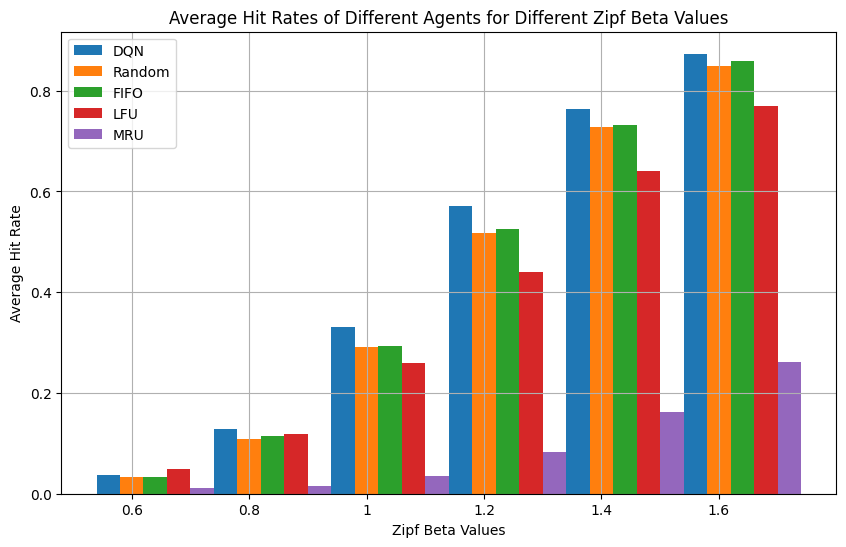

In [ ]:
from cache.Cache import Cache
from agents.CacheAgent import *
from agents.DQNAgent import DQNAgent
from agents.ReflexAgent import *
from cache.DataLoader import DataLoaderZipf
import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":
    zipf_beta_values = [0.6, 0.8, 1, 1.2, 1.4, 1.6]
    hit_rate_data = {name: [] for name in ['DQN', 'Random', 'FIFO', 'LFU', 'MRU']}

    for zipf_beta in zipf_beta_values:
        dataloader = DataLoaderZipf(5000, 1000, zipf_beta, num_progs=15)
        env = Cache(dataloader, 50,
                    feature_selection=('Base',),
                    reward_params=dict(name='our', alpha=0.5, psi=10, mu=1, zipf_beta=zipf_beta),
                    allow_skip=False
                    )

        agents = {
            'DQN': DQNAgent(env.n_actions, env.n_features,
                            learning_rate=0.01,
                            reward_decay=0.9,
                            e_greedy_min=(0.0, 0.1),
                            e_greedy_max=(0.2, 0.8),
                            e_greedy_init=(0.1, 0.5),
                            e_greedy_increment=(0.005, 0.01),
                            e_greedy_decrement=(0.005, 0.001),
                            history_size=50,
                            dynamic_e_greedy_iter=25,
                            reward_threshold=3,
                            explore_mentor='LRU',
                            replace_target_iter=100,
                            memory_size=10000,
                            batch_size=128,
                            output_graph=False,
                            verbose=0
                            ),
            'Random': RandomAgent(env.n_actions),
            'FIFO': FIFOAgent(env.n_actions),
            'LFU': LFUAgent(env.n_actions),
            'MRU': MRUAgent(env.n_actions)
        }

        for name, agent in agents.items():
            print("-------------------- %s, Zipf Beta=%s --------------------" % (name, zipf_beta))

            step = 0
            episodes = 1
            counts = []
            for episode in range(episodes):
                observation = env.reset()
                while True:
                    action = agent.choose_action(observation)
                    observation_, reward = env.step(action)

                    if env.hasDone():
                        break

                    agent.store_transition(observation, action, reward, observation_)

                    if isinstance(agent, LearnerAgent) and (step > 20) and (step % 5 == 0):
                        agent.learn()

                    observation = observation_

                    if step % 1000 == 0:
                        mr = env.miss_rate()
                        counts.append(env.total_count)

                    step += 1

            hit_rate = 1 - np.mean(env.miss_rate())  # Calculate average hit rate
            hit_rate_data[name].append(hit_rate)

    # Plotting
    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    for idx, (name, hit_rate_list) in enumerate(hit_rate_data.items()):
        plt.bar(np.arange(len(zipf_beta_values)) + idx * bar_width, hit_rate_list, bar_width, label=name)

    plt.title("Average Hit Rates of Different Agents for Different Zipf Beta Values")
    plt.xlabel("Zipf Beta Values")
    plt.ylabel("Average Hit Rate")
    plt.xticks(np.arange(len(zipf_beta_values)) + (bar_width * 2) / 2, zipf_beta_values)
    plt.legend()
    plt.grid(True)
    plt.show()


## Experiment 4

-------------------- DQN --------------------
Agent=DQN, Episode=0, Step=0: Accesses=89, Misses=52, MissRate=0.584270, Hits=37, HitRate=0.415730
Agent=DQN, Episode=0, Step=1000: Accesses=2394, Misses=1052, MissRate=0.439432, Hits=1342, HitRate=0.560568
Agent=DQN, Episode=0, Step=2000: Accesses=4511, Misses=2052, MissRate=0.454888, Hits=2459, HitRate=0.545112
Agent=DQN, Episode=0, Step=3000: Accesses=7661, Misses=3052, MissRate=0.398381, Hits=4609, HitRate=0.601619
Agent=DQN, Episode=0, Step=4000: Accesses=9663, Misses=4052, MissRate=0.419331, Hits=5611, HitRate=0.580669
Agent=DQN, Episode=0, Step=5000: Accesses=11000, Misses=5052, MissRate=0.459273, Hits=5948, HitRate=0.540727
Agent=DQN, Episode=0, Step=6000: Accesses=12359, Misses=6052, MissRate=0.489684, Hits=6307, HitRate=0.510316
Agent=DQN, Episode=0, Step=7000: Accesses=14333, Misses=7052, MissRate=0.492011, Hits=7281, HitRate=0.507989
-------------------- Random --------------------
Agent=Random, Episode=0, Step=0: Accesses=89, M

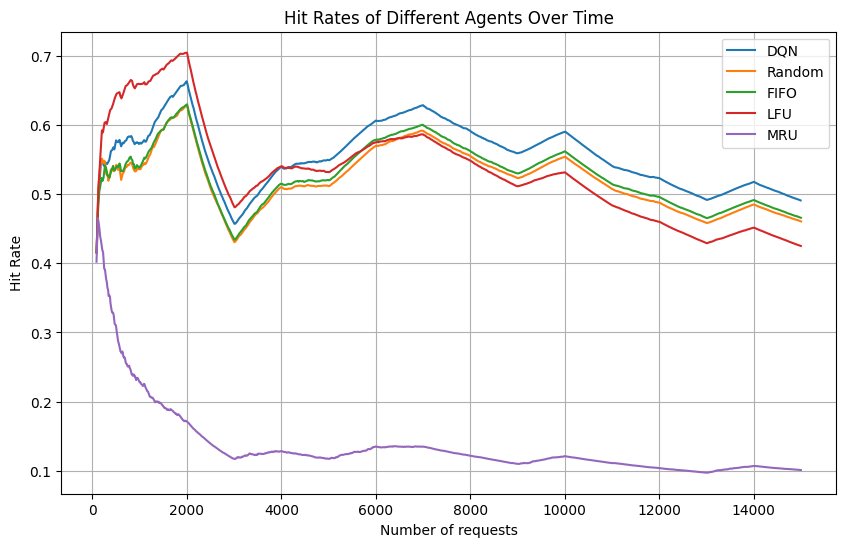

In [ ]:
from cache.Cache import Cache
from agents.CacheAgent import *
from agents.DQNAgent import DQNAgent
from agents.ReflexAgent import *
from cache.DataLoader import DataLoaderZipfMixed
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # cache
    zipf_beta = [0.6, 0.8, 1, 1.2, 1.4, 1.6]
    dataloader = DataLoaderZipfMixed(5000, 1000, zipf_beta, num_progs=15)
    env = Cache(dataloader, 50,
         feature_selection=('Base',),
         reward_params = dict(name='our', alpha=0.5, psi=10, mu=1, beta=0.3),
         allow_skip=False
    )

    # agents
    agents = {}
    agents['DQN'] = DQNAgent(env.n_actions, env.n_features,
        learning_rate=0.01,
        reward_decay=0.9,

        # Epsilon greedy
        e_greedy_min=(0.0, 0.1),
        e_greedy_max=(0.2, 0.8),
        e_greedy_init=(0.1, 0.5),
        e_greedy_increment=(0.005, 0.01),
        e_greedy_decrement=(0.005, 0.001),

        history_size=50,
        dynamic_e_greedy_iter=25,
        reward_threshold=3,
        explore_mentor = 'LRU',

        replace_target_iter=100,
        memory_size=10000,
        batch_size=128,

        output_graph=False,
        verbose=0
    )
    agents['Random'] = RandomAgent(env.n_actions)
    agents['FIFO'] = FIFOAgent(env.n_actions)
    agents['LFU'] = LFUAgent(env.n_actions)
    agents['MRU'] = MRUAgent(env.n_actions)
    hit_rates = {name: [] for name in agents}
    all_counts = []
    # all_steps = []
    for (name, agent) in agents.items():

        print("-------------------- %s --------------------" % name)

        step = 0
        episodes = 1
        # episodes = 2 if isinstance(agent, LearnerAgent) else 1
        counts = []
        steps = []
        for episode in range(episodes):
            # initial observation
            observation = env.reset()
            while True:
                # agent choose action based on observation
                action = agent.choose_action(observation)

                # agent take action and get next observation and reward
                observation_, reward = env.step(action)

                # break while loop when end of this episode
                if env.hasDone():
                    break

                agent.store_transition(observation, action, reward, observation_)

                if isinstance(agent, LearnerAgent) and (step > 20) and (step % 5 == 0):
                    agent.learn()

                # swap observation
                observation = observation_

                if step % 10 == 0:
                  hit_rate = 1 - env.miss_rate()  # Calculate hit rate
                  hit_rates[name].append(hit_rate)  # Store hit rate for the agent
                  mr = env.miss_rate()
                  counts.append(env.total_count)
                  # steps.append(step)

                if step % 1000 == 0:
                  print("Agent=%s, Episode=%d, Step=%d: Accesses=%d, Misses=%d, MissRate=%f, Hits=%d, HitRate=%f"
                      % (name, episode, step, env.total_count, env.miss_count, mr, env.total_count-env.miss_count, 1-mr)
                    )

                step += 1
        all_counts.append(counts)
        # all_steps.append(steps)

    # print(hit_rates)
    plt.figure(figsize=(10, 6))
    for idx,(name, hit_rate_list) in enumerate(hit_rates.items()):
        plt.plot(all_counts[idx], hit_rate_list, label=name)

    plt.title("Hit Rates of Different Agents Over Time")
    plt.xlabel("Number of requests")
    plt.ylabel("Hit Rate")
    plt.legend()
    plt.grid(True)
    plt.show()